In [4]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
import cv2
from sklearn.model_selection import train_test_split
import glob

In [24]:
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        # Use cv2.imread() to read the image and mask in color (BGR format)
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)  # Pass numpy arrays to albumentations
            image = augmented['image']
            mask = augmented['mask']

        # Process the mask to be 0 or 255, like in the video's augmentation step
        mask = mask / 255.0
        mask = (mask > 0.5) * 255

        # Convert mask to grayscale *before* converting to tensor
        mask = cv2.cvtColor(mask.astype(np.uint8), cv2.COLOR_BGR2GRAY)
        mask = mask / 255.0
        mask = mask > .5
        # Normalize the image to [0, 1] range *before* converting to tensor
        image = image / 255.0

        # Convert to tensor *after* augmentation and normalization
        image = torch.from_numpy(image).permute(2, 0, 1).float()  # Convert to tensor and change to CHW
        mask = torch.from_numpy(mask).unsqueeze(0).float()  # Convert mask to tensor

        return image, mask


In [25]:
from torch.utils.data import DataLoader

def create_dataloaders(train_images, train_masks, val_images, val_masks, train_tfms, val_tfms, batch_size=4):

    train_datasets = [SegmentationDataset(train_images, train_masks, transform=tfm) for tfm in train_tfms]
    train_dataset = torch.utils.data.ConcatDataset(train_datasets)

    val_dataset = SegmentationDataset(val_images, val_masks, transform=val_tfms)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers = 4,pin_memory = True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers = 4,pin_memory = True)

    return train_dataloader, val_dataloader

In [26]:
def load_data(path, split):
  images = sorted(glob.glob(path + '/*/image/*.png'))
  masks = sorted(glob.glob(path + '/*/mask/*.png'))
  print(len(images))
  print(len(masks))
  split_size = int(len(images) * split)
  train_images, val_images = train_test_split(images, test_size = split_size, random_state = 42)
  train_masks, val_masks = train_test_split(masks, test_size = split_size, random_state = 42)
  return (train_images, train_masks), (val_images, val_masks)

In [27]:
(train_images, train_masks), (val_images, val_masks) = load_data('/kaggle/input/ct-heart-segmentation/data/train', 0.2)

2532
2532


In [28]:
train_masks[0]

'/kaggle/input/ct-heart-segmentation/data/train/100092/mask/1-074.png'

In [29]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

train_tfms = [
    A.Compose([
        A.Resize(256, 256),
        # ToTensorV2() # Convert to tensor after resizing
    ]),

    A.Compose([
        A.VerticalFlip(p=1.0),
        A.Resize(256, 256),
        # ToTensorV2()
    ]),

    A.Compose([
        A.Rotate(limit=45, p=1.0),
        A.Resize(256, 256),
        # ToTensorV2()
    ]),

    A.Compose([
        A.HorizontalFlip(p=1.0),
        A.Resize(256, 256),
        # ToTensorV2()
    ])
]

val_tfms = A.Compose([
    A.Resize(256, 256),
    # ToTensorV2()
])

In [30]:
train_dataloader, val_dataloader = create_dataloaders(train_images, train_masks, val_images, val_masks, train_tfms, val_tfms, 32)

In [31]:
# Example usage:
for images, masks in train_dataloader:
    print("Image batch shape:", images[0].cpu().numpy().transpose((1, 2, 0)).shape)
    print("Mask batch shape:", masks[0].cpu().numpy().transpose((1, 2, 0)).shape)
    break  # Print only the first batch


Image batch shape: (256, 256, 3)
Mask batch shape: (256, 256, 1)


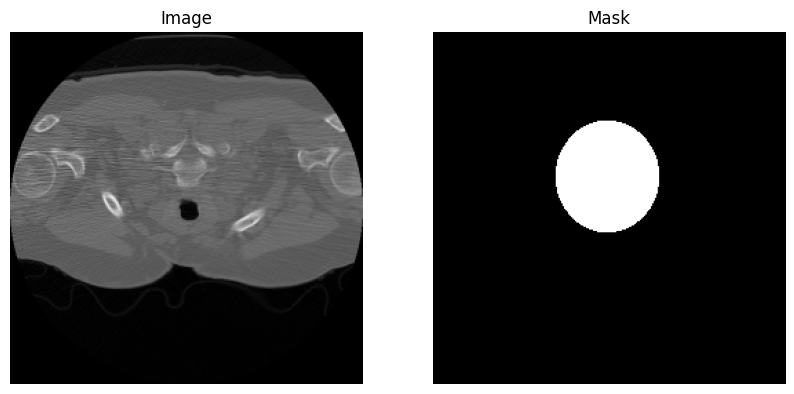

In [71]:
# Example usage:
for images, masks in train_dataloader:
    image_mat = images[-1].cpu().numpy().transpose((1, 2, 0))
    mask_mat = masks[1].cpu().numpy().transpose((1, 2, 0))
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image_mat)
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_mat,cmap='gray' )
    plt.title("Mask")
    plt.axis('off')

    plt.show()
    break;


In [72]:
# import torch
# try:
#     import torch_xla.core.xla_model as xm
# except:
#     pass

# def get_default_device():
#     try:
#         # Check if TPU is available
#         return xm.xla_device()
#     except:
#         # Fallback to GPU if TPU isn't available, otherwise CPU
#         if torch.cuda.is_available():
#             return torch.device('cuda')
#         else:
#             return torch.device('cpu')

# device = get_default_device()
# print(device)


In [73]:
# class DeviceDataLoader():
#   def __init__(self, dl, device):
#     self.dl = dl
#     self.device = device

#   def __iter__(self):
#     for b in self.dl:
#         images, masks = b
#         yield [images.to(self.device), masks.to(self.device)]

#   def __len__(self):
#     return len(self.dl)

In [74]:
# train_dataloader = DeviceDataLoader(train_dataloader, device)
# val_dataloader = DeviceDataLoader(val_dataloader, device)

In [75]:
def dice_loss(preds, targets, smooth = 1e-15):
    # ensure output are float tensors
    preds = torch.sigmoid(preds)
    preds = preds.float().view(-1)
    targets = targets.float().view(-1)

    # ensure intersection
    intersection = (preds * targets).sum()  # Corrected line
    dice = (2 * intersection + smooth)/(preds.sum() + targets.sum() + smooth)
    dice_loss = 1 - dice

    return dice_loss

In [76]:
def segmentation_accuracy(output, target):
  preds = torch.sigmoid(output)
  preds = (preds > 0.5).float()
  accuracy = (preds == target).float().mean()
  return accuracy

In [77]:
def conv2D(num_channel,number_filter,dropout):
  layer = nn.Sequential(
      nn.Conv2d(num_channel, number_filter, kernel_size = 3, stride = 1, padding = 'same'),
      nn.BatchNorm2d(number_filter),
      nn.ReLU(True),
      nn.Dropout(dropout)
  )
  return layer

In [78]:
def conv2DTranspose(num_channel, number_filter, dropout):
  layer = nn.Sequential(
      nn.ConvTranspose2d(num_channel, number_filter, kernel_size = 2, stride = (2,2), padding = 0),
      nn.BatchNorm2d(number_filter),
      nn.ReLU(True),
      nn.Dropout(dropout)
  )
  return layer

In [79]:
def conv2dCreate(input_channel, num_filters, dropout):
  layers = [
      conv2D(input_channel, num_filters, dropout),
      conv2D(num_filters, num_filters, dropout),

  ]
  max_pooling = nn.MaxPool2d(2)
  return nn.Sequential(*layers), max_pooling

In [80]:
def createDownsampling(num_layers, initial_filter, out_filter, dropout):
  layers = nn.ModuleList()
  maxpool_layers = nn.ModuleList()
  for i in range(num_layers):
    layer, max_layer = conv2dCreate(initial_filter, out_filter, dropout)
    layers.append(layer)
    maxpool_layers.append(max_layer)
    initial_filter = out_filter
    out_filter = out_filter * 2

  return layers, maxpool_layers

In [81]:
def bottle_neck(num_channel, number_filter, dropout):
    layers = [
        conv2D(num_channel, number_filter, dropout),
        conv2D(number_filter, number_filter, dropout),
    ]
    return nn.Sequential(*layers)


In [82]:
def upSamplingCreate(num_layers, initial_filter, dropout):
  layers = nn.ModuleList()
  current_filter = initial_filter
  for i in range(num_layers):
    current_filter = current_filter // 2
    layer_transpose = conv2DTranspose(initial_filter, current_filter, dropout)
    layers.append(layer_transpose)
    layer_Conv1 = conv2D(initial_filter, current_filter, dropout)
    layers.append(layer_Conv1)
    layer_Conv2 = conv2D(current_filter, current_filter, dropout)
    layers.append(layer_Conv2)
    initial_filter = current_filter
  return layers

In [83]:
import torch.nn.functional as F
import torch.nn as nn
class UNettrain(nn.Module):

  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = dice_loss(out, labels)
    accuracy = segmentation_accuracy(out, labels)
    return {"training_loss":loss, "training_accuracy" : accuracy}

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = dice_loss(out, labels)
    accuracy = segmentation_accuracy(out, labels)
    return {'val_loss': loss, 'val_accuracy': accuracy}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accuracies = [x['val_accuracy'] for x in outputs]
    epoch_acc = torch.stack(batch_accuracies).mean()
    return {'val_loss': epoch_loss.item(), 'val_accuracy': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    return "Epoch [{}],training_loss: {:.4f}, training_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['training_loss'], result['training_acc'], result['val_loss'], result['val_accuracy'])


In [84]:
class UNet(UNettrain):
    def __init__(self, in_channels, out_channels, num_layers, out_filter, dropout):
        super().__init__()
        # Initialize Downsampling layers
        self.downsampling_conv_layers, self.downsampling_maxpool_layers = createDownsampling(num_layers, in_channels, out_filter, dropout)


        # Initialize BottleNeck layers
        bottle_neck_in_channels =  (2**(num_layers-1)) * out_filter
        bottle_neck_out_channels = bottle_neck_in_channels * 2
        self.bottle_neck = bottle_neck(bottle_neck_in_channels, bottle_neck_out_channels, dropout)

        # Initialize Upasampling Layers
        self.upsampling_conv_layers = upSamplingCreate(num_layers, bottle_neck_out_channels, dropout)

        # Initialize Final Layer
        self.final_conv_layer = nn.Conv2d(out_filter, out_channels, kernel_size=1)
    def forward(self, x):
        skip_connections = []

        # Downsampling
        for conv_layer, maxpool_layer in zip(self.downsampling_conv_layers, self.downsampling_maxpool_layers):
            x = conv_layer(x)
            skip_connections.append(x)
            x = maxpool_layer(x)

        # BottleNeck
        x = self.bottle_neck(x)

        # Upsampling
        skip_connections = list(reversed(skip_connections))
        for i in range(0, len(self.upsampling_conv_layers), 3):
          skip = skip_connections[i//3]
          x = self.upsampling_conv_layers[i](x)
          x = torch.cat((x, skip), dim=1)
          x = self.upsampling_conv_layers[i+1](x)
          x = self.upsampling_conv_layers[i+2](x)

        # Final Convolution layer
        x = self.final_conv_layer(x)
        return x

In [85]:
model = UNet(3,1,4,64,.2)

In [90]:
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from torchinfo import summary
class UNetTrain(pl.LightningModule):
    def __init__(self, in_channels, out_channels, num_layers, out_filter, dropout, learning_rate=1e-3):
        super().__init__()
        # Initialize UNet architecture here
        self.downsampling_conv_layers, self.downsampling_maxpool_layers = createDownsampling(num_layers, in_channels, out_filter, dropout)
        bottle_neck_in_channels =  (2**(num_layers-1)) * out_filter
        bottle_neck_out_channels = bottle_neck_in_channels * 2
        self.bottle_neck = bottle_neck(bottle_neck_in_channels, bottle_neck_out_channels, dropout)
        self.upsampling_conv_layers = upSamplingCreate(num_layers, bottle_neck_out_channels, dropout)
        self.final_conv_layer = nn.Conv2d(out_filter, out_channels, kernel_size=1)  # Use torchmetrics Dice
        self.learning_rate = learning_rate
        self.save_hyperparameters()
        self.validation_step_outputs = []
        self.training_step_outputs = []# Add this line

    def forward(self, x):
        skip_connections = []
        # Downsampling
        for conv_layer, maxpool_layer in zip(self.downsampling_conv_layers, self.downsampling_maxpool_layers):
            x = conv_layer(x)
            skip_connections.append(x)
            x = maxpool_layer(x)
        # BottleNeck
        x = self.bottle_neck(x)
        # Upsampling
        skip_connections = list(reversed(skip_connections))
        for i in range(0, len(self.upsampling_conv_layers), 3):
            skip = skip_connections[i//3]
            x = self.upsampling_conv_layers[i](x)
            x = torch.cat((x, skip), dim=1)
            x = self.upsampling_conv_layers[i+1](x)
            x = self.upsampling_conv_layers[i+2](x)
        # Final Convolution layer
        x = self.final_conv_layer(x)
        return x

    def training_step(self, batch, batch_idx):
        images, labels = batch
        out = self(images)
        loss = dice_loss(out, labels)  # target needs to be int.
        acc = segmentation_accuracy(out, labels) 
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        out = self(images)
        loss = dice_loss(out, labels)  # target needs to be int.
        acc = segmentation_accuracy(out, labels) 
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        self.validation_step_outputs.append({'val_loss': loss, 'val_acc': acc}) # Append

        return {'val_loss': loss, 'val_acc': acc}

    def on_validation_epoch_end(self): # Changed to on_validation_epoch_end
        avg_loss = torch.stack([x['val_loss'] for x in self.validation_step_outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in self.validation_step_outputs]).mean()
        combined_metric = avg_loss - avg_acc  # Changed to subtraction
        self.validation_step_outputs.clear()  # Clear the list

        return {'val_loss': avg_loss, 'val_acc': avg_acc}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='min', 
            factor=0.1, 
            patience=10, 
            min_lr=1e-7, 
            verbose=True
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss'  # This should be the validation metric you want to monitor
            }}

    def configure_callbacks(self):
        
        early_stop_callback = pl.callbacks.EarlyStopping(
            monitor='val_loss',  # Monitor the combined metric
            min_delta=0.00,
            patience=10,
            verbose=True,
            mode='min',  # We want to minimize the combined metric
        )
        
        checkpoint_callback = ModelCheckpoint(
            monitor='val_loss',  # Monitor validation loss
            filename='best_model',  # Filename for the saved best model
            save_top_k=1,  # Save only the best model
            mode='min',  # Save when validation loss is minimized
            verbose=True
        )

        lr_monitor = LearningRateMonitor(logging_interval='epoch')

        return [early_stop_callback, checkpoint_callback, lr_monitor]
        return [early_stop_callback, lr_monitor]


In [87]:
# Example usage (assuming you have train_dataloader, val_dataloader):
model = UNetTrain(
    in_channels=3,  # Example: 1 for grayscale CT scans
    out_channels=1,  # Example: 1 for binary segmentation
    num_layers=4,
    out_filter=64,
    dropout=0,
    learning_rate=1e-4
)
input_size = (32,3,256,256)
summary(model, input_size)

Layer (type:depth-idx)                   Output Shape              Param #
UNetTrain                                [32, 1, 256, 256]         --
├─ModuleList: 1-7                        --                        (recursive)
│    └─Sequential: 2-1                   [32, 64, 256, 256]        --
│    │    └─Sequential: 3-1              [32, 64, 256, 256]        1,920
│    │    └─Sequential: 3-2              [32, 64, 256, 256]        37,056
├─ModuleList: 1-8                        --                        --
│    └─MaxPool2d: 2-2                    [32, 64, 128, 128]        --
├─ModuleList: 1-7                        --                        (recursive)
│    └─Sequential: 2-3                   [32, 128, 128, 128]       --
│    │    └─Sequential: 3-3              [32, 128, 128, 128]       74,112
│    │    └─Sequential: 3-4              [32, 128, 128, 128]       147,840
├─ModuleList: 1-8                        --                        --
│    └─MaxPool2d: 2-4                    [32, 128, 

In [28]:
import torch
torch.cuda.empty_cache()

In [32]:
trainer = pl.Trainer(
    devices=1,  # or 2 for multiple T4 GPUs
    accumulate_grad_batches=4,  # Accumulate gradients for 4 steps to simulate a larger batch size
    max_epochs=40,
    precision='16-mixed',
)  # Adjust max_epochs as needed
# trainer.fit(model, train_dataloader, val_dataloader)

NameError: name 'pl' is not defined

In [37]:
# Get the path to the best model checkpoint
best_model_path = trainer.checkpoint_callback.best_model_path
print(f"Best model path: {best_model_path}")

Best model path: /kaggle/working/lightning_logs/version_2/checkpoints/best_model.ckpt


In [38]:
import shutil

# Get the best model checkpoint path
best_model_path = trainer.checkpoint_callback.best_model_path
print(f"Best model path: {best_model_path}")

# Define the destination path in /kaggle/working
destination_path = "/kaggle/working/best_model.ckpt"

# Copy the checkpoint to the destination
shutil.copy(best_model_path, destination_path)
print(f"Model saved to {destination_path}")

Best model path: /kaggle/working/lightning_logs/version_2/checkpoints/best_model.ckpt
Model saved to /kaggle/working/best_model.ckpt


In [ ]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import gc

def fit(model, train_loader, val_loader, epochs, optimizer, patience=10):
    history = []
    best_val_loss = float('inf')  # Initialize best validation loss as infinity
    epochs_without_improvement = 0  # Counter to track the number of epochs with no improvement

    for epoch in range(epochs):
        model.train()
        train_results = []
        for batch in tqdm(train_loader):
            batch_results = model.training_step(batch)
            loss = batch_results['training_loss']
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_results.append(batch_results)
            torch.cuda.empty_cache()  # Clear unused memory
            gc.collect()  # Garbage collection

        # Validation
        model.eval()
        val_results = []
        with torch.no_grad():
            for batch in tqdm(val_loader):
                batch_results = model.validation_step(batch)
                val_results.append(batch_results)
        prind('finished epoch')
        result = model.validation_epoch_end(val_results)
        print("finished result")
        val_loss = result['val_loss']  # Assuming 'val_loss' is part of the validation result
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0  # Reset counter if improvement
        else:
            epochs_without_improvement += 1

        # If no improvement in `patience` epochs, stop early
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

        # Record results for this epoch
        result['training_loss'] = torch.stack([x['training_loss'] for x in train_results]).mean().item()
        result['training_acc'] = torch.stack([x['training_accuracy'] for x in train_results]).mean().item()
        emodel.epoch_end(epoch, result)
        history.append(result)

    return history


In [26]:
model.to(device) # transfer the model to the device.
print(device)

xla:0


In [ ]:
history = fit(model, train_dataloader, val_dataloader, 10, torch.optim.Adam(model.parameters()))

100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


In [14]:
import pydicom as dicom

In [62]:
test_x = glob.glob("/kaggle/input/ct-heart-segmentation/data/test/*/*/*.dcm")

In [63]:
def load_test_images(paths):
    images = []
    for path in paths:
        image = dicom.dcmread(path).pixel_array
        images.append(image)
    return images

In [64]:
test_images = load_test_images(test_x)

In [103]:
def convert_test_image(image):
    # resize images
    image = cv2.resize(image, (256,256)) # now shape (H,W)
    # expand dimension
    image = np.expand_dims(image, axis = -1) # now shape (H,W,1)

    # normalize image by dividing by 255 but first divide by max value
    image = (image/np.max(image)) * 255.0
    return image

In [104]:
def augment_test_images(images):
    """
    this function normalize and resize the test_images 
    """
    augmented_images = []

    # loop through each image
    for image in images:
        # convert image
        image = convert_test_image(image)
        image = image/255.0

        # Concatenate each image 3 times 
        image = np.concatenate([image,image,image],axis = -1) #now shape (H,W,3)
        
        image = torch.from_numpy(image).permute(2, 0, 1).float()

        # append augmented image to augmented images list
        augmented_images.append(image)
    return augmented_images

In [105]:
# create augmented test images
augmented_test = augment_test_images(test_images)

In [112]:
# create test dataloader
test_dataloader = DataLoader(augmented_test, batch_size = 64, shuffle=False,num_workers = 4,pin_memory = True )

In [113]:
best_model_path = '/kaggle/input/myunetmodel/pytorch/default/1/best_model.ckpt'

In [114]:
in_channels = 3  # Example value
out_channels = 1  # Example value
num_layers = 4  # Example value
out_filter = 64  # Example value
dropout = 0  # Example value
learning_rate = 1e-3  # Example value


In [115]:
model = UNetTrain.load_from_checkpoint(
    best_model_path,
    in_channels=in_channels,
    out_channels=out_channels,
    num_layers=num_layers,
    out_filter=out_filter,
    dropout=dropout,
    learning_rate=learning_rate
)

# Set to evaluation mode
model.eval()
model.freeze()
model.to('cuda')
print(model.device)

cuda:0


In [146]:
import torch
import os
from torchvision.transforms.functional import to_pil_image

# Initialize an empty list to store predictions
predictions_mask = []
predictions_concatenated = []
# Disable gradient computation for inference
i = 0
with torch.no_grad():
    for images in test_dataloader:
        # If DataLoader provides only images
        images = images.to(model.device)  # Move to the same device as the model
        outputs = model(images)

        preds = torch.sigmoid(outputs)
        # Apply a threshold to convert outputs to binary masks
        preds = (outputs > 0.5)
        preds = preds.cpu().numpy().astype(np.int32)
        preds = preds * 255
        

        # Convert predictions to PIL images or save them
        for pred in preds:
            image = convert_test_image(test_images[i]).astype(np.int32)
            predicted_mask = pred.transpose(1,2,0)
            concatenated_image = np.concatenate([image, predicted_mask], axis = 1)

            predictions_mask.append(predicted_mask)
            predictions_concatenated.append(concatenated_image)
            os.makedirs('predicted-images',exist_ok = True)
            cv2.imwrite('predicted-images/image_test_{}.png'.format(i),concatenated_image)
            i = i + 1
        print('Finished Batch')
            
            

Finished Batch
Finished Batch
Finished Batch
Finished Batch
Finished Batch
Finished Batch
Finished Batch
Finished Batch
Finished Batch
Finished Batch
Finished Batch
Finished Batch
Finished Batch


In [147]:
import shutil

# Define the source directory
source_dir = "/kaggle/working/predicted-images"  # Update this with the actual folder name
destination_zip = "/kaggle/working/predicted-images.zip"

# Create a zip file of the directory
shutil.make_archive(destination_zip.replace('.zip', ''), 'zip', source_dir)

print(f"Directory zipped as: {destination_zip}")


Directory zipped as: /kaggle/working/predicted-images.zip
